Import des librairies
- pixiedust (Kernel Python/Scala)
- time

In [1]:
#import pixiedust
import time
import os
import tweepy
import json
import json_lines


Configuration du nom du fichier utilisé

In [2]:
%env TIME={time.time()}
%env OUTPUT_TWEET_FILENAME=output_tweet_{os.environ['TIME']}.json
%env TWEET_JSON_FILENAME=input_tweet_{os.environ['TIME']}.json


env: TIME=1521642018.6679099
env: OUTPUT_TWEET_FILENAME=output_tweet_1521642018.6679099.json
env: TWEET_JSON_FILENAME=input_tweet_1521642018.6679099.json


In [3]:
with_geo=False
API_key = json.load(open("API_key.txt", "r"))

auth = tweepy.OAuthHandler(API_key["consumer_key"], API_key["consumer_secret"])
auth.set_access_token(API_key["access_token"], API_key["access_token_secret"])
api = tweepy.API(auth)

keyword = "bitcoin"

tweets = api.search( q=keyword,tweet_mode='extended',include_rts=False,count=2000)

json_tweets=[]
for tweet in tweets:
    json_tweets.append(json.dumps(tweet._json))

json_str = "\n".join(json_tweets)

filename = "tweets-database/"+os.environ['TWEET_JSON_FILENAME']
with open(filename, "w") as f:
    f.write(json_str)

Envoie des tweets collectés sur le datacenter

In [4]:
%%bash
cp tweets-database/$TWEET_JSON_FILENAME Algo1/$TWEET_JSON_FILENAME
cd Algo1
sbt "put $TWEET_JSON_FILENAME"

[info] Loading settings from idea.sbt ...
[info] Loading global plugins from /Users/Frego/.sbt/1.0/plugins
[info] Loading settings from plugins.sbt ...
[info] Loading project definition from /Users/Frego/Documents/Centrale/4A/OPTION/08_Projet/SparkSenti/Algo1/project
[info] Loading settings from build.sbt ...
[info] Set current project to SparkSenti (in build file:/Users/Frego/Documents/Centrale/4A/OPTION/08_Projet/SparkSenti/Algo1/)
spawn scp input_tweet_1521642018.6679099.json fregosi1@sparksenti:.
fregosi1@sparksenti's password: 
input_tweet_1521642018.6679099.json           100%  483KB   7.7MB/s   00:00    
spawn ssh fregosi1@sparksenti
fregosi1@sparksenti's password: 

Welcome to Bright release         7.3

                                                        Based on CentOS Linux 7
                                                                    ID: #000002

Use the following commands to adjust your environment:

'module avail'            - show available modules
'module ad

Execution de l'analyse de sentiments des tweets colléctés sur le datacenter

In [5]:
%%bash
cd Algo1
rm -rf $TWEET_JSON_FILENAME
sbt "submit $TWEET_JSON_FILENAME"

[info] Loading settings from idea.sbt ...
[info] Loading global plugins from /Users/Frego/.sbt/1.0/plugins
[info] Loading settings from plugins.sbt ...
[info] Loading project definition from /Users/Frego/Documents/Centrale/4A/OPTION/08_Projet/SparkSenti/Algo1/project
[info] Loading settings from build.sbt ...
[info] Set current project to SparkSenti (in build file:/Users/Frego/Documents/Centrale/4A/OPTION/08_Projet/SparkSenti/Algo1/)
spawn ssh fregosi1@sparksenti
fregosi1@sparksenti's password: 

Welcome to Bright release         7.3

                                                        Based on CentOS Linux 7
                                                                    ID: #000002

Use the following commands to adjust your environment:

'module avail'            - show available modules
'module add <module>'     - adds a module to your environment for this session
'module initadd <module>' - configure module to be loaded at every login

--------------------------------------

Récupération du resultat de l'analyse : fichier text (id_tweet sentiment)

In [6]:
%%bash
cd Algo1
sbt "getOutput 'defaultoutput.json'"
cp defaultoutput.json ../tweets-database/$OUTPUT_TWEET_FILENAME
rm -rf defaultoutput.json

[info] Loading settings from idea.sbt ...
[info] Loading global plugins from /Users/Frego/.sbt/1.0/plugins
[info] Loading settings from plugins.sbt ...
[info] Loading project definition from /Users/Frego/Documents/Centrale/4A/OPTION/08_Projet/SparkSenti/Algo1/project
[info] Loading settings from build.sbt ...
[info] Set current project to SparkSenti (in build file:/Users/Frego/Documents/Centrale/4A/OPTION/08_Projet/SparkSenti/Algo1/)
spawn scp fregosi1@sparksenti:'defaultoutput.json' .
fregosi1@sparksenti's password: 
defaultoutput.json                            100%  487KB   3.6MB/s   00:00    

[success] Total time: 1 s, completed 21 mars 2018 15:22:25


Pour test de viz (evite de lancer le workflow complet)

In [25]:
%env OUTPUT_TWEET_FILENAME=output_test.json
%env TWEET_JSON_FILENAME=input_test.json

env: OUTPUT_TWEET_FILENAME=output_test.json
env: TWEET_JSON_FILENAME=input_test.json


In [25]:
#file_json = open("tweets-database/"+os.environ['OUTPUT_TWEET_FILENAME'],"r", encoding="utf8");


file_json = open("tweets-database/output_tweet_1521642018.6679099.json","r", encoding="utf8");
reader = json_lines.reader(file_json)

In [15]:
import folium
import random
from geopy.geocoders import Nominatim
geolocator = Nominatim(timeout=3)



WASH_COORD = [38.8949549, -77.0366456]
NYC_COORD = [40.7128, -74.0059]
LYON_COORD = [45.750000,4.850000]
CHICAGO_COORD = [41.850033, -87.6500523]
US_COORD = [39,-95]

# Build map 
map_main = folium.Map(location=US_COORD, 
                      zoom_start=4, 
                      tiles='cartodbpositron', 
                      width=640, 
                      height=400)



import itertools           #  ======> sert à limiter le nombre de tweets afficher sur la carte
#for tweet in itertools.islice(reader, 30):
#for tweet in reader :      # =======> sert à afficher tout les tweets

for tweet in itertools.islice(reader, 10):
    if (tweet['tweet']!= ''):
        location = geolocator.geocode(tweet['tweet']['user']['location'])
        popup_image ='''<img src="''' + tweet['tweet']['user']['profile_image_url'] + '''" alt="pic " />'''
        popup_text = '<b>'+tweet['tweet']['user']['name']+'</b>' + ' tweeted : '+ '<i>' + tweet['tweet']['full_text'] + '</i>'
        popup = '<center>' + popup_image + '<br\><br\>' + popup_text + '</center>'
        location = [location.latitude + random.gauss(0,0000.1), location.longitude + random.gauss(0,000.1)]
        if tweet['result'] == 'Positif':
            folium.Marker(location,                               
                          popup= popup,
                          #popup= folium.Popup(test, max_width=2650),
                          icon=folium.Icon(color='green')
                         ).add_to(map_main)
        elif tweet['result'] == 'Negatif':
            folium.Marker(location,   
                          popup= popup,
                          icon=folium.Icon(color='red')
                         ).add_to(map_main)            
        elif tweet['result'] == 'Neutre':
            folium.Marker(location,   
                          popup= popup,
                          icon=folium.Icon(color='lightgray')
                         ).add_to(map_main)                    




# Display map in Jupyter
map_main

JSONDecodeError: Expecting property name enclosed in double quotes: line 1 column 2 (char 1)

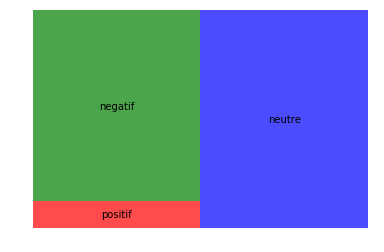

In [12]:
import squarify 
import matplotlib.pyplot as plt

y=[0,0,0];
with open('tweets-database/output_tweet_1521640131.3454146.json', 'rb') as f:
    for tweet in json_lines.reader(f):
        if tweet['result'] == 'Positif':
            y[0]+=1
        elif tweet['result'] == 'Negatif':
            y[1]+=1
        elif tweet['result'] == 'Neutre':
            y[2]+=1
x=["positif","negatif","neutre"];   
squarify.plot(sizes=y, label=x, alpha=.7 ,color=["red","green","blue"])
plt.axis('off')
plt.show()
